# Laser simulator
https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines

Given:
- a geometric map of the environment defined in an analytical form (lines of segments),
- the sensor properties:
    - FOV
    - resolution
    - maximum working distance
    - a characterization of the sensor noise
- a sensor pose

Simulate a measurement of the said environment.

Let's go!

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot

# The Laser2D class

In [2]:
class Laser2D():

  def __init__(self, FOV, resolution, max_distance, noise_cov, pose):
    """Constructor of the class, called each time an object is created.

    Keyword arguments:
    FOV -- Sensor field of view (radians)
    resolution -- Sensor resolution (radians)
    max_distance -- Max operating distance of the sensor (meters)
    noise_cov -- covariance matriz characterizing sensor noise
    pose -- sensor pose (column vector with x and y positions, and orientation theta)
    """
    self.FOV = FOV
    self.resolution = resolution
    self.max_distance = max_distance
    self.noise_cov = noise_cov
    self.pose = pose
    self.last_z = np.array([])

  def set_pose(self, pose):  
    """Sets the sensor pose to a new one"""
    self.pose = pose

  def take_observation(self, map):
    """Takes a sensor observation from its current pose to the map.


    Keyword arguments:
    map -- Map consisting of line segments (rows index x and y segments' 
            coordinates, while cols index segments' points)
    Returns:
    z -- array of dimensions (2,n_beams), where the rows index measurement 
        distances and angles, that is: np.array([[rho0,...,rho_n_beams],
        [phi0,...,phi_n_beams])
    """

    # Useful variables
    n_beams = math.floor(self.FOV / self.resolution) + 1
    seg_distance = np.sqrt(pow(map[0,:-1]-map[0,1:],2)+pow(map[1,:-1]-map[1,1:],2))
    z = np.zeros([2,n_beams])

    # Iterate over laser beams
    for i_beam in range(n_beams):

      # Get beam orientation and final position
      phi = i_beam*resolution-(FOV/2) + self.pose[2]

      # Angle warp
      if phi > np.pi: phi -= 2*np.pi
      elif phi < -np.pi: phi += 2*np.pi

      # Compute beam endpoint (go through walls)
      x_beam = self.pose[0] + self.max_distance*np.cos(phi)
      y_beam = self.pose[1] + self.max_distance*np.sin(phi)      

      d = self.max_distance # Sensor measurement, max_distance by default

      # Check intersections with environment (Iterate over lines)
      for i_line in range(map.shape[1]-1):

        # Compute intersection with line        
        xdiff = (map[0,i_line] - map[0,i_line+1], self.pose[0] - x_beam)
        ydiff = (map[1,i_line] - map[1,i_line+1], self.pose[1] - y_beam)
        
        # Auxiliary function for computing the determinant
        def det(a, b):
          return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0: # lines do not intersect
          continue
        
        de = (det(map[:,i_line],map[:,i_line+1]), det(self.pose[:-1],[x_beam, y_beam]) )
        x = det(de, xdiff) / div
        y = det(de, ydiff) / div

        d_to_intersect = np.sqrt(pow(self.pose[0]-x,2)+pow(self.pose[1]-y,2))

        # Check pertenence to segment (the intersection between two lines
        # could happend out of the segment)
        d1 = np.sqrt(pow(map[0,i_line]-x,2)+pow(map[1,i_line]-y,2))[0]
        d2 = np.sqrt(pow(map[0,i_line+1]-x,2)+pow(map[1,i_line+1]-y,2))[0]
        th_for_corners = 0.05

        if (d1 < seg_distance[i_line]+th_for_corners and 
            d2 < seg_distance[i_line]+th_for_corners):                
        
          # Check direction (the intersection could happend in the opposite
          # direction of the beam!)
          phi_m = math.atan2(0-(x-self.pose[0]),(y-self.pose[1])-0)+90*np.pi/180
          
          # Angle warp
          if phi_m > np.pi: phi_m -= 2*np.pi
          elif phi_m < -np.pi: phi_m += 2*np.pi

          if np.sign(phi) == np.sign(phi_m):            

            # Check if it is the closest distance (we need the closest intersection)
            if d_to_intersect < d:
              d = d_to_intersect

      # Store the measurement for this beam (adding noise!)
      z[0,i_beam] = d + np.random.normal(0, np.sqrt(self.noise_cov[0][0]))
      z[1,i_beam] = i_beam*self.resolution-(self.FOV/2) + np.random.normal(0, np.sqrt(self.noise_cov[1][1]))

    
    return z

  def draw_observation(self, z, pose, fig, ax):
    for i in range (z.shape[1]):
      z_i = z[:,i]
      x = pose[0]+z_i[0]*np.cos(z_i[1]+pose[2])      
      y = pose[1]+z_i[0]*np.sin(z_i[1]+pose[2])
      ax.plot([x,pose[0]],[y,pose[1]],'g--',linewidth=0.5)
      ax.plot(x,y,'ro')

# Usage example

C:\Users\isidr\AppData\Local\Temp\ipykernel_12292\187382699.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_m = math.atan2(0-(x-self.pose[0]),(y-self.pose[1])-0)+90*np.pi/180
C:\Users\isidr\AppData\Local\Temp\ipykernel_12292\187382699.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[0,i_beam] = d + np.random.normal(0, np.sqrt(self.noise_cov[0][0]))


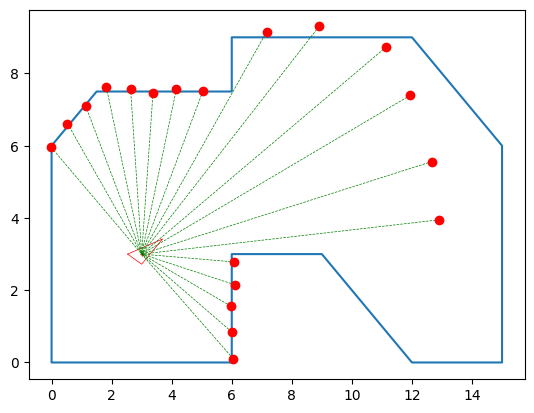

In [3]:
# Define the environment
map = np.array([[0, 0, 4, 4, 6, 8, 10, 10, 8, 4, 4, 1, 0], 
                [4, 0, 0, 2, 2, 0, 0, 4, 6, 6, 5, 5, 4]])*1.5
fig, ax = plt.subplots()
#plt.xlim([-2,17]), plt.ylim([-2,11]),
plt.plot(map[0,:],map[1,:])

# Set robot pose and drow it
robot_pose = np.vstack([3., 3., np.pi/4]) # [x,y,theta]
DrawRobot(fig, ax, robot_pose, color='red')

# Prepare the laser
FOV = 180 * np.pi/180        # radians
resolution = 10 * np.pi/180  #radians
max_distance = 10         # meters
noise_cov = np.array([[0.005, 0],[0, 0.0002]]) # covariance matrix
laser_pose = robot_pose   # [x,y,theta]


# Take and draw an observation!
laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
z = laser.take_observation(map)
laser.draw_observation(z,laser_pose,fig,ax)
plt.show()